## Baseline Type Classfication 

Goal is to build a baseline type classification model using XGBoost with original track-level summary statistics to establish a performance baseline

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   

# Suppress df assignment warning
pd.options.mode.chained_assignment = None  

labels = pd.read_csv("../data/type_label.csv")
detections = pd.read_csv("../data/detections_radar_smoothed.csv")

#### Use ais tracks & tagged tracks as train/test/val

In [13]:
# Pre-process detections
from tagger_v2.utils.scripts.sum_stats import SumStats

summary_df = SumStats().generate_summary_data(detections)

#### Aggregate Types from EDA insights

In [17]:
#Examine original types
combined_tracks_with_labels = labels.merge(summary_df, on = "id_track", how = "left")
combined_tracks_with_labels['type_m2_agg'].value_counts()

type_m2_agg
cargo/tanker      6103
class_b           2371
passenger_ship    2093
other             1304
tug/tow            875
military_ship      449
pleasure_craft     288
fishing_boat       163
Name: count, dtype: int64

#### XGBoost for 8-class type classification

Baseline 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

features_subset = ['min_speed', 'max_speed', 'avg_speed', 'curviness', 'heading_mean', 'heading_std', 
 'turning_mean', 'turning_std', 'distance_total', 'distance_o']

# Prepare features and target
X = combined_tracks_with_labels[features_subset]
y = combined_tracks_with_labels['type_m2_agg']

#Type to number mapping
ship2num, num2ship = {}, {}
num = 0
for vessel in y.unique():
    ship2num[vessel] = num
    num2ship[num] = vessel
    num += 1
y_numeric = y.map(ship2num)

# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [13, 15],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators': [200, 350]
}

# Perform 5-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
Best cross-validation accuracy: 0.7537

Test Set Accuracy: 0.7531


In [30]:
from sklearn.metrics import f1_score
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))
print("\nTrain Set Accuracy: {:.4f}".format(train_accuracy))
print(f1_score(y_test, y_pred, average="macro"), f1_score(y_train, best_model.predict(X_train), average="macro"))


Test Set Accuracy: 0.7531

Train Set Accuracy: 1.0000
0.4849764435578753 1.0


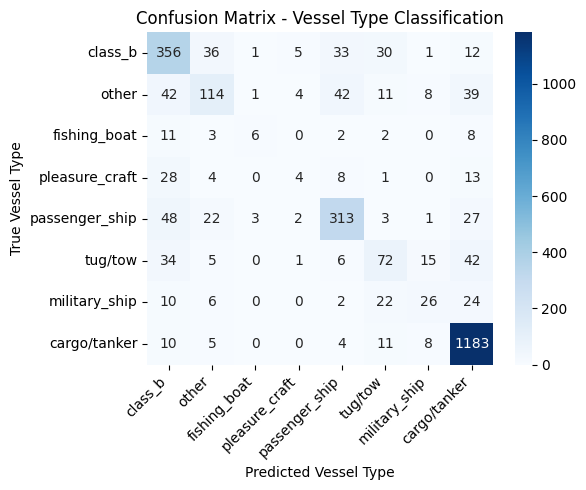

In [19]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(6, 5))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(ship2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(ship2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

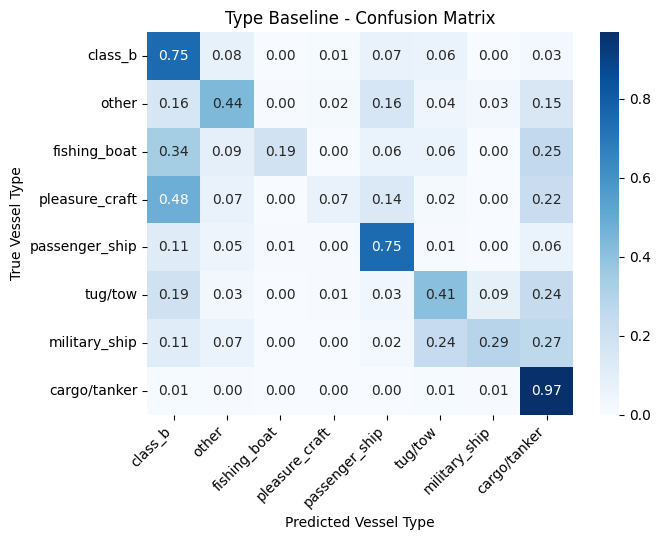

In [26]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(7, 5.5))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Type Baseline - Confusion Matrix')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

<Figure size 1000x800 with 0 Axes>

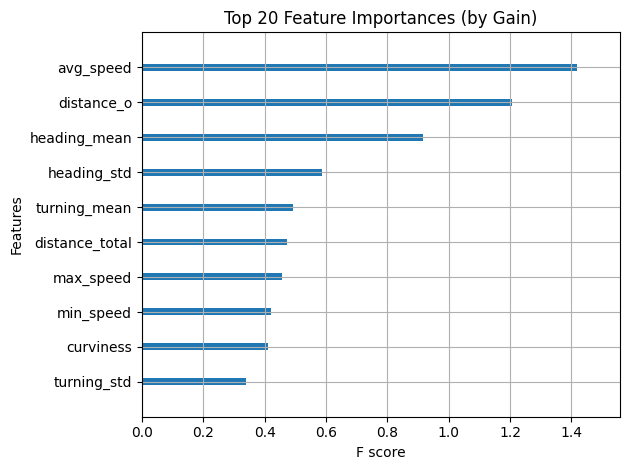

In [21]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Top 20 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()
